In [1]:
!pip install torch torchvision torchattacks matplotlib numpy

Installing and importing all the packages (torchattacks)

In [2]:
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

Loading CIFAR-10 dataset

In [3]:
# Load CIFAR-10 datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:04<00:00, 41095234.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Modify the final layer of the pre-trained ResNet model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


Using device: cpu


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.1MB/s]


In [5]:
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [7]:
# Training function
def train_model(model, trainloader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader)}')

# Fine-tune the model
train_model(model, trainloader, criterion, optimizer, device, epochs=5)


Epoch [1/5], Loss: 0.7446217015385628
Epoch [2/5], Loss: 0.5446780389547348
Epoch [3/5], Loss: 0.41405546844005586
Epoch [4/5], Loss: 0.30803328594565393
Epoch [5/5], Loss: 0.22766776821017265


In [8]:
# Evaluate model accuracy
def evaluate_model(model, testloader, device):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

baseline_accuracy = evaluate_model(model, testloader, device)
print(f'Baseline Accuracy after fine-tuning: {baseline_accuracy:.2f}%')


Baseline Accuracy after fine-tuning: 79.29%


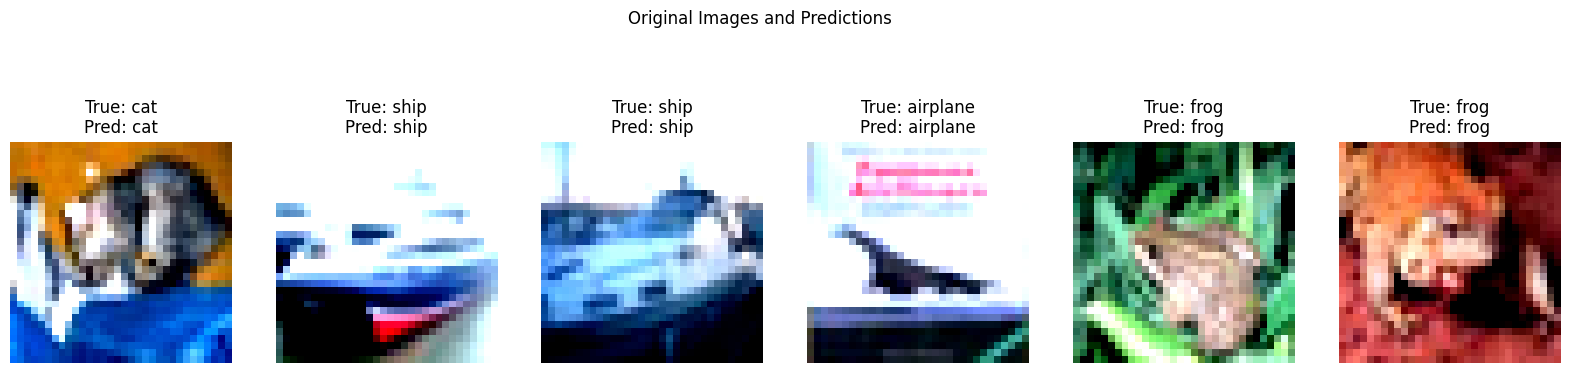

In [9]:
# Function to show images with full names for labels and predictions
def show_images(images, labels, predicted, title):
    images = images / 2 + 0.5  # unnormalize
    npimg = images.cpu().numpy()
    fig, axs = plt.subplots(1, 6, figsize=(20, 5))
    for idx in range(6):
        axs[idx].imshow(np.transpose(npimg[idx], (1, 2, 0)))
        true_label = testset.classes[labels[idx]]
        pred_label = testset.classes[predicted[idx]]
        axs[idx].set_title(f'True: {true_label}\nPred: {pred_label}')
        axs[idx].axis('off')
    fig.suptitle(title)
    plt.show()

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Original images and predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)
show_images(images.cpu(), labels.cpu(), predicted.cpu(), 'Original Images and Predictions')


FGSM Attack Success Rate: 71.22%


Original Label: ship
Adversarial Label: airplane


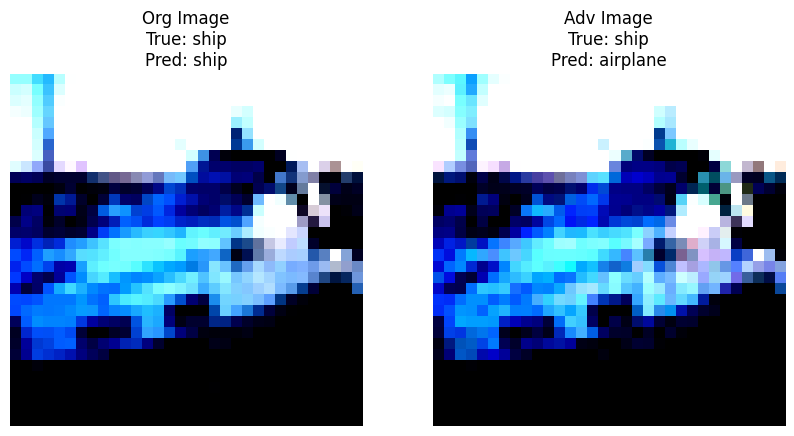

In [24]:
# FGSM Attack Success Rate and Visualization
# Define the FGSM attack
epsilon = 0.1
fgsm_attack = torchattacks.FGSM(model, eps=epsilon)

# Evaluate the FGSM attack success rate
def evaluate_fgsm_success_rate(model, attack, testloader, device):
    correct = 0
    total = 0

    model.eval()
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        # Ensure inputs require gradient
        images.requires_grad = True

        # Generate adversarial examples
        adv_images = attack(images, labels)

        # Evaluate the model on adversarial examples
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    attack_success_rate = 100 - (100 * correct / total)
    return attack_success_rate

# Perform the FGSM attack and print the success rate
fgsm_success_rate = evaluate_fgsm_success_rate(model, fgsm_attack, testloader, device)
print(f'FGSM Attack Success Rate: {fgsm_success_rate:.2f}%')

# Visualize FGSM adversarial images and predictions
def show_fgsm_adversarial_images(attack):
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # First find an image that the model predicts correctly and misclassifies after the attack
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    found = False
    for i in range(len(images)):
        if predicted[i] == labels[i]:
            original_image = images[i].unsqueeze(0)
            original_label = labels[i].unsqueeze(0)
            adv_image = attack(original_image, original_label)
            adv_output = model(adv_image)
            _, adv_predicted = torch.max(adv_output, 1)
            if adv_predicted[0] != original_label:
                found = True
                break

    if not found:
        print("No successful FGSM attack found in the batch.")
        return

    # Print the original and adversarial predictions
    print(f"Original Label: {testset.classes[original_label.item()]}")
    print(f"Adversarial Label: {testset.classes[adv_predicted[0].item()]}")

    # Visualize the original and adversarial images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(np.transpose(original_image.squeeze().cpu().numpy(), (1, 2, 0)))
    axes[0].set_title(f"Org Image\nTrue: {testset.classes[original_label.item()]}\nPred: {testset.classes[predicted[i].item()]}")
    axes[0].axis('off')

    axes[1].imshow(np.transpose(adv_image.squeeze().cpu().numpy(), (1, 2, 0)))
    axes[1].set_title(f"Adv Image\nTrue: {testset.classes[original_label.item()]}\nPred: {testset.classes[adv_predicted[0].item()]}")
    axes[1].axis('off')

    plt.show()

# Show FGSM adversarial images and predictions
show_fgsm_adversarial_images(fgsm_attack)


VANILA Attack Success Rate: 20.71%


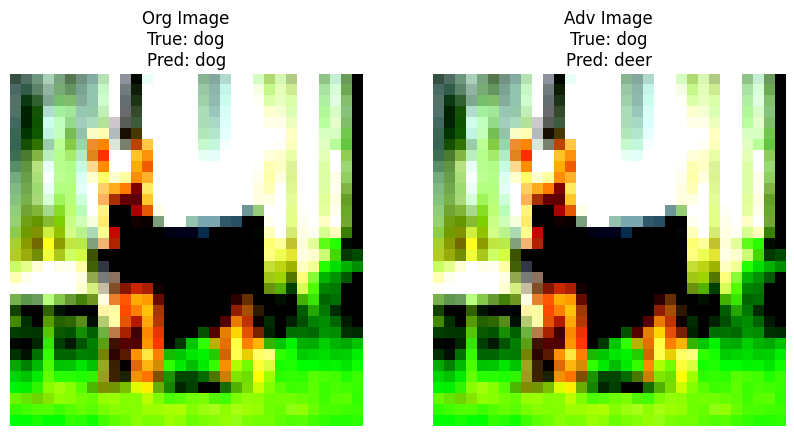

In [29]:
# VANILA Attack Success Rate and Visualization
# Define the VANILA attack
vanila_attack = torchattacks.VANILA(model)

# Evaluate the VANILA attack success rate
def evaluate_vanila_success_rate(model, attack, testloader, device):
    correct = 0
    total = 0
    successful_attacks = []

    model.eval()
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        # Ensure inputs require gradient
        images.requires_grad = True

        # Generate adversarial examples
        adv_images = attack(images, labels)

        # Evaluate the model on adversarial examples
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect successful attack examples
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                successful_attacks.append((images[i].detach().cpu(), labels[i].detach().cpu(), adv_images[i].detach().cpu(), predicted[i].detach().cpu()))

    attack_success_rate = 100 - (100 * correct / total)
    return attack_success_rate, successful_attacks

# Perform the VANILA attack and print the success rate
vanila_success_rate, successful_attacks_vanila = evaluate_vanila_success_rate(model, vanila_attack, testloader, device)
print(f'VANILA Attack Success Rate: {vanila_success_rate:.2f}%')

# Visualize VANILA adversarial images and predictions
def show_vanila_adversarial_images(successful_attacks):
    if successful_attacks:
        original_image, original_label, adv_image, adv_predicted = successful_attacks[0]

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(np.transpose(original_image.squeeze().numpy(), (1, 2, 0)))
        axes[0].set_title(f"Org Image\nTrue: {testset.classes[original_label.item()]}\nPred: {testset.classes[original_label.item()]}")
        axes[0].axis('off')

        axes[1].imshow(np.transpose(adv_image.squeeze().numpy(), (1, 2, 0)))
        axes[1].set_title(f"Adv Image\nTrue: {testset.classes[original_label.item()]}\nPred: {testset.classes[adv_predicted.item()]}")
        axes[1].axis('off')

        plt.show()
    else:
        print("No successful VANILA attack found in the dataset.")

# Show VANILA adversarial images and predictions
show_vanila_adversarial_images(successful_attacks_vanila)


GN Attack Success Rate: 57.47%


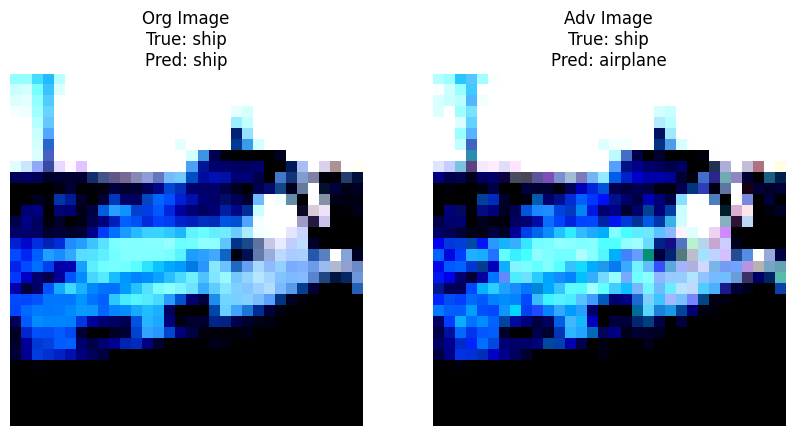

In [30]:
# GN Attack Success Rate and Visualization
# Define the GN attack
gn_attack = torchattacks.GN(model, std=0.1)

# Evaluate the GN attack success rate
def evaluate_gn_success_rate(model, attack, testloader, device):
    correct = 0
    total = 0
    successful_attacks = []

    model.eval()
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        # Ensure inputs require gradient
        images.requires_grad = True

        # Generate adversarial examples
        adv_images = attack(images, labels)

        # Evaluate the model on adversarial examples
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect successful attack examples
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                successful_attacks.append((images[i].detach().cpu(), labels[i].detach().cpu(), adv_images[i].detach().cpu(), predicted[i].detach().cpu()))

    attack_success_rate = 100 - (100 * correct / total)
    return attack_success_rate, successful_attacks

# Perform the GN attack and print the success rate
gn_success_rate, successful_attacks_gn = evaluate_gn_success_rate(model, gn_attack, testloader, device)
print(f'GN Attack Success Rate: {gn_success_rate:.2f}%')

# Visualize GN adversarial images and predictions
def show_gn_adversarial_images(successful_attacks):
    if successful_attacks:
        original_image, original_label, adv_image, adv_predicted = successful_attacks[0]

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(np.transpose(original_image.squeeze().numpy(), (1, 2, 0)))
        axes[0].set_title(f"Org Image\nTrue: {testset.classes[original_label.item()]}\nPred: {testset.classes[original_label.item()]}")
        axes[0].axis('off')

        axes[1].imshow(np.transpose(adv_image.squeeze().numpy(), (1, 2, 0)))
        axes[1].set_title(f"Adv Image\nTrue: {testset.classes[original_label.item()]}\nPred: {testset.classes[adv_predicted.item()]}")
        axes[1].axis('off')

        plt.show()
    else:
        print("No successful GN attack found in the dataset.")

# Show GN adversarial images and predictions
show_gn_adversarial_images(successful_attacks_gn)


BIM Attack Success Rate: 53.52%


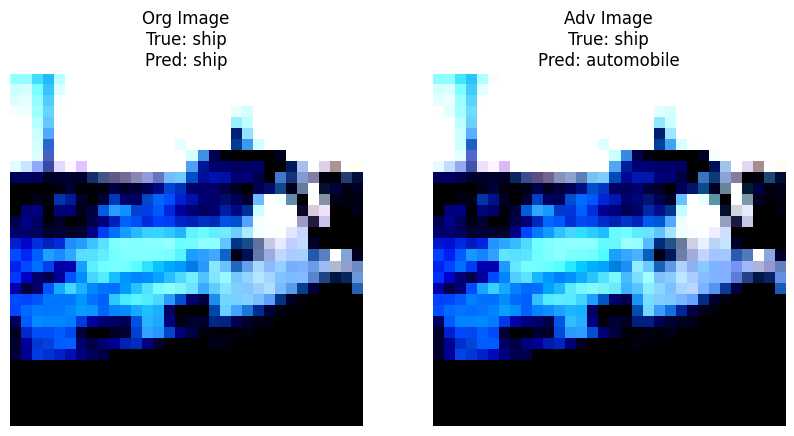

In [31]:
# BIM Attack Success Rate and Visualization
# Define the BIM attack
bim_attack = torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=10)

# Evaluate the BIM attack success rate
def evaluate_bim_success_rate(model, attack, testloader, device):
    correct = 0
    total = 0
    successful_attacks = []

    model.eval()
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        # Ensure inputs require gradient
        images.requires_grad = True

        # Generate adversarial examples
        adv_images = attack(images, labels)

        # Evaluate the model on adversarial examples
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect successful attack examples
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                successful_attacks.append((images[i].detach().cpu(), labels[i].detach().cpu(), adv_images[i].detach().cpu(), predicted[i].detach().cpu()))

    attack_success_rate = 100 - (100 * correct / total)
    return attack_success_rate, successful_attacks

# Perform the BIM attack and print the success rate
bim_success_rate, successful_attacks_bim = evaluate_bim_success_rate(model, bim_attack, testloader, device)
print(f'BIM Attack Success Rate: {bim_success_rate:.2f}%')

# Visualize BIM adversarial images and predictions
def show_bim_adversarial_images(successful_attacks):
    if successful_attacks:
        original_image, original_label, adv_image, adv_predicted = successful_attacks[0]

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(np.transpose(original_image.squeeze().numpy(), (1, 2, 0)))
        axes[0].set_title(f"Org Image\nTrue: {testset.classes[original_label.item()]}\nPred: {testset.classes[original_label.item()]}")
        axes[0].axis('off')

        axes[1].imshow(np.transpose(adv_image.squeeze().numpy(), (1, 2, 0)))
        axes[1].set_title(f"Adv Image\nTrue: {testset.classes[original_label.item()]}\nPred: {testset.classes[adv_predicted.item()]}")
        axes[1].axis('off')

        plt.show()
    else:
        print("No successful BIM attack found in the dataset.")

# Show BIM adversarial images and predictions
show_bim_adversarial_images(successful_attacks_bim)
